In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image libraries
import cv2

In [85]:
# directories
train_img_path = 'train'
test_img_path = 'test'

w,h = 32,32
batch_size = 32

train_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    train_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [86]:
train_Dataset.class_indices

{'FAKE': 0, 'REAL': 1}

In [87]:
train_Dataset.image_shape

(32, 32, 3)

# CNN Model

In [88]:
# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 2, 2, 128)       

In [89]:
# Save best model
weight_path = 'best_weights'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
) 

In [90]:
history = model.fit(train_Dataset, epochs=5, validation_data=test_Dataset, callbacks=[model_checkpoint])

Epoch 1/5
3125/3125 [==============================] - 40s 13ms/step - loss: 0.3502 - accuracy: 0.8471 - val_loss: 0.2422 - val_accuracy: 0.8982
Epoch 2/5
3125/3125 [==============================] - 42s 14ms/step - loss: 0.2419 - accuracy: 0.9028 - val_loss: 0.2093 - val_accuracy: 0.9139
Epoch 3/5
3125/3125 [==============================] - 44s 14ms/step - loss: 0.2107 - accuracy: 0.9163 - val_loss: 0.1958 - val_accuracy: 0.9220
Epoch 4/5
3125/3125 [==============================] - 42s 13ms/step - loss: 0.1874 - accuracy: 0.9267 - val_loss: 0.1776 - val_accuracy: 0.9280
Epoch 5/5
3125/3125 [==============================] - 42s 13ms/step - loss: 0.1683 - accuracy: 0.9346 - val_loss: 0.2234 - val_accuracy: 0.9148


In [91]:
# load best weights to model
model.load_weights(weight_path)

# make prediction
predictions = model.predict(test_Dataset)

625/625 [==============================] - 7s 11ms/step


In [92]:
predictions[11000]

array([0.99465275], dtype=float32)

In [93]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

# Visualize Result

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10000
           1       0.94      0.92      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



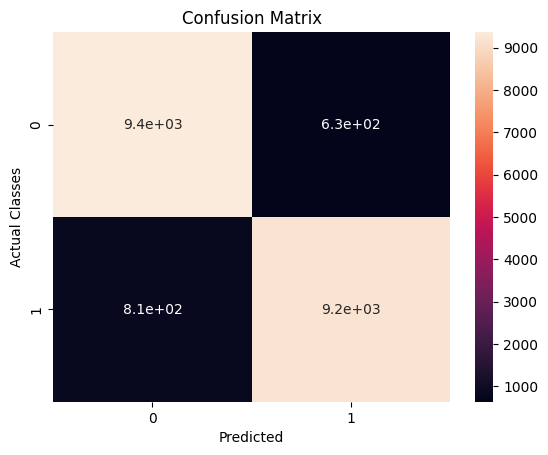

In [94]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()
